In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from mettoolbox import mettoolbox as met
from tstoolbox import tstoolbox as ts

In [2]:
help(met)

Help on module mettoolbox.mettoolbox in mettoolbox:

NAME
    mettoolbox.mettoolbox - # -*- coding: utf-8 -*-

FUNCTIONS
    about()
        Display version number and system information.
    
    allen_cli(lat, temp_min_col, temp_max_col, source_units, temp_mean_col=None, start_date=None, end_date=None, dropna='no', clean=False, round_index=None, skiprows=None, index_type='datetime', names=None, target_units=None, print_input=False, tablefmt='csv')
        Allen PET: f(Tmin, Tmax, Tavg, latitude)
        
        Average daily temperature can be supplied or if not, calculated by
        (Tmax+Tmin)/2.
        
        Parameters
        ----------
        lat: float
            The latitude of the station.  Positive specifies the Northern
            Hemisphere, and negative values represent the Southern
            Hemisphere.
        
        temp_min_col: str, int
            The column name or number (data columns start numbering at 1) in
            the input data that represents

In [3]:
data_obs_hourly = pd.read_csv("data_obs_hourly.csv", index_col=0, parse_dates=True)
data_obs_daily = ts.read("data_obs_daily.csv")
plot_period = slice("2014-07-01", "2014-07-05")

In [4]:
# data_obs_hourly[['precip','hum']].to_csv('data_obs_hourly_precip_hum.csv')
# data_obs_hourly['temp'].to_csv('data_obs_hourly_temp.csv')

In [5]:
data_obs_daily

,temp,tmin,tmax,precip,glob,hum,hum_min,hum_max,wind
Datetime,,,,,,,,,
2014-06-01,284.4125,280.55,288.95,0.2,3951.6,82.166667,66,91,0.254167
2014-06-02,286.120833,279.65,291.15,0.0,6205.8,74.958333,54,94,0.3875
2014-06-03,286.708333,281.25,292.05,2.6,5620.2,83.875,60,93,0.3125
2014-06-04,287.454167,282.55,293.35,4.4,5605.9,84.416667,64,96,0.645833
2014-06-05,285.258333,281.05,289.35,1.0,5125.2,78.5,57,97,1.3125
...,...,...,...,...,...,...,...,...,...
2014-08-27,286.029167,282.25,291.45,1.0,5048.2,85.125,63,98,0.15
2014-08-28,287.495833,280.85,293.85,0.4,4943.1,85.208333,70,95,0.5875
2014-08-29,289.475,286.45,294.55,0.0,3022.9,88.416667,66,97,0.225


<b>Temperature<b>

sine_min_max
sine_mean
mean_course_mean
mean_course_min_max


Text(0, 0.5, 'Temperature [K]')

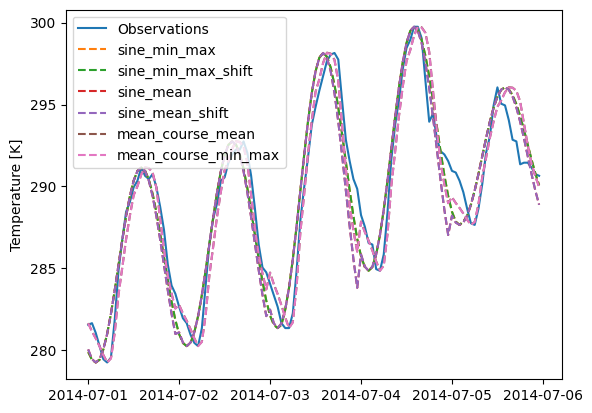

In [6]:
tempdf_mettoolbox = pd.DataFrame()
plt.plot(data_obs_hourly["temp"].loc[plot_period])
temp_methods = ["sine_min_max", "sine_mean", "mean_course_mean", "mean_course_min_max"]
for method in temp_methods:
    print(method)
    if method in ["sine_min_max", "sine_mean"]:
        tempdf_mettoolbox[method] = met.disaggregate.temperature(
            input_ts=data_obs_daily,
            temp_min_col=2,
            temp_max_col=3,
            method=method,
            min_max_time="sun_loc",
            source_units=["degK", "degK"],
            target_units=["degK"],
            lat=51.00,
            lon=8.86,
            max_delta=False,
        )
        plt.plot(tempdf_mettoolbox[method].loc[plot_period], "--")
        tempdf_mettoolbox[method + "_shift"] = met.disaggregate.temperature(
            input_ts=data_obs_daily,
            temp_min_col=2,
            temp_max_col=3,
            method=method,
            min_max_time="sun_loc_shift",
            source_units=["degK", "degK"],
            target_units=["degK"],
            lat=51.00,
            lon=8.86,
            hourly="data_obs_hourly_temp.csv",
            max_delta=False,
        )
        plt.plot(tempdf_mettoolbox[method].loc[plot_period], "--")
    else:
        tempdf_mettoolbox[method] = met.disaggregate.temperature(
            input_ts=data_obs_daily,
            temp_min_col=2,
            temp_max_col=3,
            method=method,
            source_units=["degK", "degK"],
            target_units=["degK"],
            lat=51.00,
            lon=8.86,
            hourly="data_obs_hourly_temp.csv",
            max_delta=False,
        )
        plt.plot(tempdf_mettoolbox[method].loc[plot_period], "--")
plt.legend(["Observations"] + list(tempdf_mettoolbox.columns))
plt.ylabel("Temperature [K]")

In [7]:
tempdf_mettoolbox.iloc[0:20, :]

,sine_min_max,sine_min_max_shift,sine_mean,sine_mean_shift,mean_course_mean,mean_course_min_max
2014-06-01 00:00:00,281.112693,281.780152,281.112693,281.780152,282.275604,282.3875
2014-06-01 01:00:00,280.693112,281.112693,280.693112,281.112693,281.803769,281.915665
2014-06-01 02:00:00,280.55,280.693112,280.55,280.693112,281.35187,281.463766
2014-06-01 03:00:00,280.693112,280.55,280.693112,280.55,280.953136,281.065032
2014-06-01 04:00:00,281.112693,280.693112,281.112693,280.693112,280.657408,280.769304
2014-06-01 05:00:00,281.780152,281.112693,281.780152,281.112693,280.438104,280.55
2014-06-01 06:00:00,282.65,281.780152,282.65,281.780152,280.933199,281.045095
2014-06-01 07:00:00,283.66296,282.65,283.66296,282.65,282.355351,282.467247
2014-06-01 08:00:00,284.75,283.66296,284.75,283.66296,283.851177,283.963073
2014-06-01 09:00:00,285.83704,284.75,285.83704,284.75,285.133314,285.24521


<b>Wind Speed<b>

equal
random
cosine


Text(0, 0.5, 'Wind speed [m/s]')

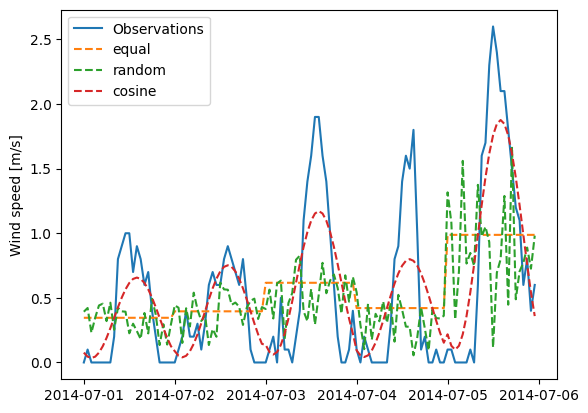

In [8]:
plt.plot(data_obs_hourly["wind"].loc[plot_period])
winddf_mettoolbox = pd.DataFrame()
wind_methods = ["equal", "random", "cosine"]
for method in wind_methods:
    print(method)
    winddf_mettoolbox[method] = met.disaggregate.wind_speed(
        input_ts=data_obs_daily,
        method=method,
        columns=9,
        a=0.9,
        b=1,
        t_shift=14.0,
        source_units=["m/s"],
    )
    plt.plot(winddf_mettoolbox[method].loc[plot_period], "--")


plt.legend(["Observations"] + wind_methods)
plt.ylabel("Wind speed [m/s]")

### Humidty

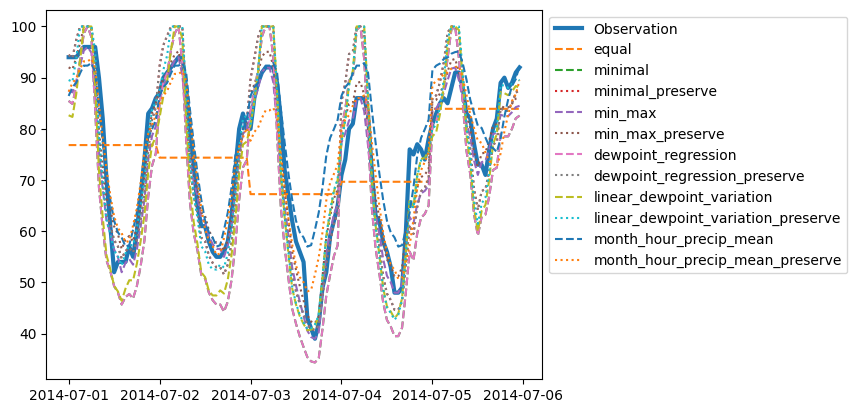

In [9]:
humiditydf_mettoolbox = pd.DataFrame()
humiditydf_mettoolbox["equal"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="equal",
    hum_mean_col=6,
    source_units=["dimensionless"],
)
humiditydf_mettoolbox["minimal"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="minimal",
    temp_min_col=2,
    source_units=["degK"],
    target_units=["degK"],  # this is expecting degK
    hourly_temp="data_obs_hourly_temp.csv",
)
humiditydf_mettoolbox["minimal_preserve"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="minimal",
    temp_min_col=2,
    source_units=["dimensionless", "dimensionless"],
    hourly_temp="data_obs_hourly_temp.csv",
    preserve_daily_mean=6,
)
humiditydf_mettoolbox["min_max"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="min_max",
    temp_min_col=2,
    temp_max_col=3,
    hum_min_col=7,
    hum_max_col=8,
    source_units=["dimensionless", "dimensionless", "dimensionless", "dimensionless"],
    hourly_temp="data_obs_hourly_temp.csv",
)
humiditydf_mettoolbox["min_max_preserve"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="min_max",
    temp_min_col=2,
    temp_max_col=3,
    hum_min_col=7,
    hum_max_col=8,
    source_units=[
        "dimensionless",
        "dimensionless",
        "dimensionless",
        "dimensionless",
        "dimensionless",
    ],
    hourly_temp="data_obs_hourly_temp.csv",
    preserve_daily_mean=6,
)
humiditydf_mettoolbox["dewpoint_regression"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="dewpoint_regression",
    temp_min_col=2,
    source_units=["degK"],
    target_units=["degK"],  # this is expecting degK
    hourly_temp="data_obs_hourly_temp.csv",
    a0=0,
    a1=1,
)
humiditydf_mettoolbox["dewpoint_regression_preserve"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="dewpoint_regression",
    temp_min_col=2,
    source_units=["dimensionless", "dimensionless"],
    hourly_temp="data_obs_hourly_temp.csv",
    a0=0,
    a1=1,
    preserve_daily_mean=6,
)
humiditydf_mettoolbox["linear_dewpoint_variation"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="linear_dewpoint_variation",
    temp_min_col=2,
    source_units=["degK"],
    target_units=["degK"],  # this is expecting degK
    hourly_temp="data_obs_hourly_temp.csv",
    a0=0,
    a1=1,
    kr=6,
)
humiditydf_mettoolbox["linear_dewpoint_variation_preserve"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="linear_dewpoint_variation",
    temp_min_col=2,
    source_units=["dimensionless", "dimensionless"],
    hourly_temp="data_obs_hourly_temp.csv",
    a0=0,
    a1=1,
    kr=6,
    preserve_daily_mean=6,
)
humiditydf_mettoolbox["month_hour_precip_mean"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="month_hour_precip_mean",
    precip_col=4,
    source_units=["dimensionless"],
    hourly_precip_hum="data_obs_hourly_precip_hum.csv",
)
humiditydf_mettoolbox["month_hour_precip_mean_preserve"] = met.disaggregate.humidity(
    input_ts=data_obs_daily,
    method="month_hour_precip_mean",
    precip_col=4,
    source_units=["dimensionless", "dimensionless"],
    hourly_temp="data_obs_hourly_temp.csv",
    hourly_precip_hum="data_obs_hourly_precip_hum.csv",
    preserve_daily_mean=6,
)


methods = humiditydf_mettoolbox.columns
plt.plot(data_obs_hourly["hum"].loc[plot_period], "-", linewidth=3)

for method in methods:
    if "preserve" in method:
        plt.plot(humiditydf_mettoolbox[method].dropna().loc[plot_period], ":")
    else:
        plt.plot(humiditydf_mettoolbox[method].dropna().loc[plot_period], "--")
plt.legend(["Observation"] + list(methods), bbox_to_anchor=(1, 1))

In [10]:
humiditydf_mettoolbox

,equal,minimal,minimal_preserve,min_max,min_max_preserve,dewpoint_regression,dewpoint_regression_preserve,linear_dewpoint_variation,linear_dewpoint_variation_preserve,month_hour_precip_mean,month_hour_precip_mean_preserve
2014-06-01 00:00:00,82.166667,87.922845,91.465992,85.345238,88.00744,87.922845,91.465992,85.066288,90.705308,92.083333,89.381944
2014-06-01 01:00:00,82.166667,90.934787,94.477934,86.833333,89.495536,90.934787,94.477934,87.754564,93.393584,92.833333,90.131944
2014-06-01 02:00:00,82.166667,95.996751,99.539897,89.214286,91.876488,95.996751,99.539897,93.22471,98.86373,94.083333,91.381944
2014-06-01 03:00:00,82.166667,100.0,100.0,91.0,93.662202,100.0,100.0,98.360806,100.0,94.583333,91.881944
2014-06-01 04:00:00,82.166667,100.0,100.0,91.0,93.662202,100.0,100.0,99.859545,100.0,94.666667,91.965278
...,...,...,...,...,...,...,...,...,...,...,...
2014-08-31 19:00:00,86.416667,78.227212,87.427782,84.694444,87.5625,78.227212,87.427782,80.808141,89.916425,84.192308,83.579744
2014-08-31 20:00:00,86.416667,87.492358,96.692928,89.888889,92.756944,87.492358,96.692928,89.597382,98.705666,87.961538,87.348974
2014-08-31 21:00:00,86.416667,94.771545,100.0,93.555556,96.423611,94.771545,100.0,95.600597,100.0,90.038462,89.425897
2014-08-31 22:00:00,86.416667,97.346539,100.0,94.777778,97.645833,97.346539,100.0,96.501484,100.0,91.923077,91.310513
